# Problem set 4: APIs, SQL, and supervised machine learning

**Total points (without extra credit)**: 48 


## Resources from class

### APIs
- [Lecture slides](https://docs.google.com/presentation/d/1eblPOhpOL1HDFk3XOh3KvcrFceJ4pwZNUU_fvU8i7uo/edit#slide=id.p)
- [Activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/06_apis_solutions.ipynb)


### Supervised ML
- [Lecture slides 1](https://docs.google.com/presentation/d/1V6X9aYkYLvyh3Ea0ZSn3qkttqKz7OOPkfvbqYybMi5Q/edit#slide=id.p)
- [Lecture slides 2](https://docs.google.com/presentation/d/13xJTI_GZ2HZYI9OSmezwLUXXFxIrjwHXKz50QUjBF0w/edit)
- [Intro activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/08_ML_intro_activity_solutions.ipynb)
- [Part II activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/08_ML_optimization_activity_solutions.ipynb)
- [DataCamp course](https://app.datacamp.com/learn/courses/supervised-learning-with-scikit-learn)

### SQL
- [Lecture slides](https://docs.google.com/presentation/d/1HHgrkFtuhGIaPNMd1EOiM-8VtgnF0cwjMcmah8oWmWA/edit?usp=sharing)
- [Example code](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/09_SQL_examplecode.ipynb)
- [Activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/09_SQL_activity_solutions.ipynb)
- [DataCamp course](https://app.datacamp.com/learn/courses/introduction-to-sql)

# Prep work: change SQL dataset

- Place it in [the same credentials yaml file on GitHub that contains the SQL database access information](https://github.com/herbertfreeze/QSS_public/blob/main/activities/09_db_cred.yaml) (password, host, etc.) 
    - Name the combined credentials file something appropriate (feel free to get creative)
    - Change the database name from `sentencing` to `math_gencompare`

## 0.0 Import packages

**Note you need to install some of the packages imported below (see the comments).**

In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import string
import requests
import plotnine 
from plotnine import *
import matplotlib.pyplot as plt
import yaml
#import warnings
#warnings.filterwarnings("ignore")

## note: you may need to install these using !pip install
#!pip install census
#!pip install us
import census
from census import Census
import us
from us import states
import mysql.connector

## sklearn imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


def load_creds(path: str):
    with open(path, 'r') as stream:
        try:
            creds = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return(creds)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)



In [2]:
creds = load_creds("../QSS20/pset4.yaml")

In [3]:
comb = mysql.connector.connect(
    user = creds["practice_database"]["user"],
    password = creds["practice_database"]["password"],
    port = creds["practice_database"]["port"],
    database = creds["practice_database"]["database"],
    host = creds["practice_database"]["host"])
comb

# 1. Write a wrapper function to pull data from the NAEP API (12 points)

In the class activity on APIs (see link above), we practiced pulling from the API for the National Assessment of Educational Progress (NAEP), "America's report card" of test scores. We pulled a small amount of data at the national level (writing scores by gender) using a query where the parameters were hardcoded.
    
In this problem, we'll practice pulling a larger set of data and writing a wrapper function.
    
As a reminder, the documentation is here: https://www.nationsreportcard.gov/api_documentation.aspx

The base link is: https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx

## 1.1 Write a query to pull 8th-grade mathematics scores in 2015 from the state of California (CA) by gender (1 point)

- Subject: mathematics 
- Subscale: MRPCM composite scale 
- Grade: 8
- Year: 2015
- grouping variable: GENDER 
- Jurisdiction: CA 
- stattype = MN (for mean)

Print the output in dataframe format and briefly interpret; what do scores look like between the genders?

In [4]:
example_naep_query = (
'https://www.nationsreportcard.gov/'
'Dataservice/GetAdhocData.aspx?'
'type=data&subject=mathematics&grade=8&'
'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015')


example_naep_query

'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015'

In [5]:
naep_resp = requests.get(example_naep_query)
naep_resp_j = naep_resp.json()
naep_resp_d = pd.DataFrame(naep_resp_j['result'])
naep_resp_d

year sample yearSampleLabel  Cohort CohortLabel stattype subject  grade  scale jurisdiction  jurisLabel variable variableLabel varValue varValueLabel       value  isStatDisplayable  errorFlag
0  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  275.020977                  1          0
1  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  275.638637                  1          0

## Females scored 0.6 points highers than males in this example which is relatively negligible when the total values are in the hundreds

## 1.2 Write a query to pull 8th-grade mathematics scores in 2013, 2015, 2017, and 2019 from California by gender (1 point)

Same as 1.1 but pull the years 2013, 2015, 2017, and 2019 (search documentation for how to combine) in one query

In [6]:
example2_naep_query = (
'https://www.nationsreportcard.gov/'
'Dataservice/GetAdhocData.aspx?'
'type=data&subject=mathematics&grade=8&'
'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019')
example2_naep_query

'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019'

In [7]:
naep_resp2 = requests.get(example2_naep_query)
naep_resp_j2 = naep_resp2.json()
naep_resp_d2 = pd.DataFrame(naep_resp_j2['result'])
naep_resp_d2

year sample yearSampleLabel  Cohort CohortLabel stattype subject  grade  scale jurisdiction  jurisLabel variable variableLabel varValue varValueLabel       value  isStatDisplayable  errorFlag
0  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  277.167171                  1          0
1  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  274.597824                  1          0
2  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  275.020977                  1          0
3  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  275.638637                  1          0
4  2017     R3            2017       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  276.608704                  1          0
5  2017     R3            2017       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  276.669430                  1          0
6  2019     R3            2019       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  274.511628                  1          0
7  2019     R3            2019       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  276.721824                  1          0

## 1.3 Create a line plot to show variation in the scores across years (2 points)

Using the results from 1.2, create a plot where the x axis has the year and the y axis is the math scores (`value` in dataframe), and there are separate lines/colors for male versus female students (`varValueLabel` in dataframe)

Start the limits of the y axis minimum at 272 and add informative labels. Be sure your x-axis is ticked on odd years, because NAEP scores skip even years. 

(272.0, 280.167170641967)

Text(0, 0.5, 'Math Scores')

Text(0.5, 0, 'Year')

Text(0.5, 1.0, 'Math Scores of Male and Female Students')

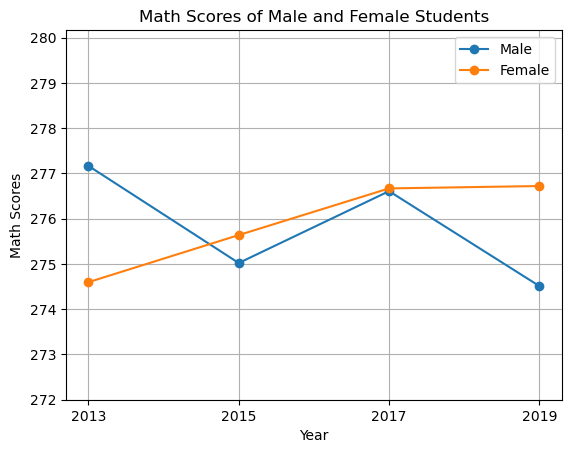

In [8]:
male_data = naep_resp_d2[naep_resp_d2['varValueLabel'] == 'Male']
female_data = naep_resp_d2[naep_resp_d2['varValueLabel'] == 'Female']

fig, ax = plt.subplots()

ax.set_ylim(272, max(naep_resp_d2['value']) + 3)
ax.set_ylabel("Math Scores")

plt.plot(male_data['yearSampleLabel'], male_data['value'], label='Male', marker='o')
plt.plot(female_data['yearSampleLabel'], female_data['value'], label='Female', marker='o')

plt.xlabel("Year")
plt.title("Math Scores of Male and Female Students")
plt.legend()

plt.grid(True)
plt.show()


## 1.4 Reproduce the queries from 1.1 and 1.2 using a user-defined function (4 points)

Create a function, `construct_naep_query` that takes in two arguments:

- year: this should be a list with all years (so if one year, single element list; if multiple years, list with those years)
- place: this should be a string with the name of the state or jurisdiction to pull 
    
Have the function return the query and make sure it's identical to the queries you wrote for 1.1 and 1.2 (can use assert or other checker)

In [9]:
def construct_naep_query(year, place):
    year_string = ','.join(year)  
    return('https://www.nationsreportcard.gov/'
                 'Dataservice/GetAdhocData.aspx?'
                 'type=data&subject=mathematics&grade=8&'
                 'subscale=MRPCM&variable=GENDER&jurisdiction='+place+'&stattype=MN:MN&Year='+year_string)


query_func = construct_naep_query(["2011","2013"], "CA")
query_func

'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2011,2013'

In [10]:
naep_resp3 = requests.get(query_func)
naep_resp_j3 = naep_resp3.json()
naep_resp_d3 = pd.DataFrame(naep_resp_j3['result'])
naep_resp_d3

year sample yearSampleLabel  Cohort CohortLabel stattype subject  grade  scale jurisdiction  jurisLabel variable variableLabel varValue varValueLabel       value  isStatDisplayable  errorFlag
0  2011     R3            2011       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  272.886065                  1          0
1  2011     R3            2011       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  272.647217                  1          0
2  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  277.167171                  1          0
3  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  274.597824                  1          0

## 1.5 Write and execute user-defined function that takes in a query and returns a pandas dataframe with the content of the response (4 points)

- Write a user-defined function (`process_naep_query`) that takes in the CA-specific NAEP query as a string, calls the API, and transforms the response into a pandas dataframe. Have the function return that pandas dataframe

- Make sure the function is flexible enough to handle queries that return an error; for queries that return an error, have the function return the string "Data not found; check your query" (see [API part 1 solutions code](https://github.com/herbertfreeze/QSS_public/blob/main/activities/solutions/06_apis_solutions.ipynb) for an example of `try:`/`except:`)

- Execute the function on the query that pulls 2013-2019 data (either from handwriting the query or the result in 1.4)

- Print the resulting dataframe

- Then execute the function on a query that pulls a state that doesn't exist (call this state ZZ)

In [11]:
def process_naep_query(query):
    try:
        response = requests.get(query)
        response.raise_for_status()

        data = response.json()
        df = pd.DataFrame(data)

        return df
    except:
        print('Data not found; check your query')


query_valid = 'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019'
result_valid = process_naep_query(query_valid)
result_valid
query_non_existent_state = 'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=ZZ&stattype=MN:MN&Year=2013'
result_non_existent_state = process_naep_query(query_non_existent_state)
result_non_existent_state


status                                                                                                                                                                                                                                                                                                                                                                                   result
0     200    {'year': 2013, 'sample': 'R3', 'yearSampleLabel': '2013', 'Cohort': 2, 'CohortLabel': 'Grade 8', 'stattype': 'MN:MN', 'subject': 'MAT', 'grade': 8, 'scale': 'MRPCM', 'jurisdiction': 'CA', 'jurisLabel': 'California', 'variable': 'GENDER', 'variableLabel': 'Gender', 'varValue': '1', 'varValueLabel': 'Male', 'value': 277.167170641967, 'isStatDisplayable': 1, 'errorFlag': 0}
1     200  {'year': 2013, 'sample': 'R3', 'yearSampleLabel': '2013', 'Cohort': 2, 'CohortLabel': 'Grade 8', 'stattype': 'MN:MN', 'subject': 'MAT', 'grade': 8, 'scale': 'MRPCM', 'jurisdiction': 'CA', 'jurisLabel': 'California', 'variable': 'GENDER', 'variableLabel': 'Gender', 'varValue': '2', 'varValueLabel': 'Female', 'value': 274.597823860242, 'isStatDisplayable': 1, 'errorFlag': 0}
2     200    {'year': 2015, 'sample': 'R3', 'yearSampleLabel': '2015', 'Cohort': 2, 'CohortLabel': 'Grade 8', 'stattype': 'MN:MN', 'subject': 'MAT', 'grade': 8, 'scale': 'MRPCM', 'jurisdiction': 'CA', 'jurisLabel': 'California', 'variable': 'GENDER', 'variableLabel': 'Gender', 'varValue': '1', 'varValueLabel': 'Male', 'value': 275.020976636682, 'isStatDisplayable': 1, 'errorFlag': 0}
3     200  {'year': 2015, 'sample': 'R3', 'yearSampleLabel': '2015', 'Cohort': 2, 'CohortLabel': 'Grade 8', 'stattype': 'MN:MN', 'subject': 'MAT', 'grade': 8, 'scale': 'MRPCM', 'jurisdiction': 'CA', 'jurisLabel': 'California', 'variable': 'GENDER', 'variableLabel': 'Gender', 'varValue': '2', 'varValueLabel': 'Female', 'value': 275.638637274477, 'isStatDisplayable': 1, 'errorFlag': 0}
4     200     {'year': 2017, 'sample': 'R3', 'yearSampleLabel': '2017', 'Cohort': 2, 'CohortLabel': 'Grade 8', 'stattype': 'MN:MN', 'subject': 'MAT', 'grade': 8, 'scale': 'MRPCM', 'jurisdiction': 'CA', 'jurisLabel': 'California', 'variable': 'GENDER', 'variableLabel': 'Gender', 'varValue': '1', 'varValueLabel': 'Male', 'value': 276.60870373867, 'isStatDisplayable': 1, 'errorFlag': 0}
5     200  {'year': 2017, 'sample': 'R3', 'yearSampleLabel': '2017', 'Cohort': 2, 'CohortLabel': 'Grade 8', 'stattype': 'MN:MN', 'subject': 'MAT', 'grade': 8, 'scale': 'MRPCM', 'jurisdiction': 'CA', 'jurisLabel': 'California', 'variable': 'GENDER', 'variableLabel': 'Gender', 'varValue': '2', 'varValueLabel': 'Female', 'value': 276.669430435038, 'isStatDisplayable': 1, 'errorFlag': 0}
6     200    {'year': 2019, 'sample': 'R3', 'yearSampleLabel': '2019', 'Cohort': 2, 'CohortLabel': 'Grade 8', 'stattype': 'MN:MN', 'subject': 'MAT', 'grade': 8, 'scale': 'MRPCM', 'jurisdiction': 'CA', 'jurisLabel': 'California', 'variable': 'GENDER', 'variableLabel': 'Gender', 'varValue': '1', 'varValueLabel': 'Male', 'value': 274.511628087454, 'isStatDisplayable': 1, 'errorFlag': 0}
7     200  {'year': 2019, 'sample': 'R3', 'yearSampleLabel': '2019', 'Cohort': 2, 'CohortLabel': 'Grade 8', 'stattype': 'MN:MN', 'subject': 'MAT', 'grade': 8, 'scale': 'MRPCM', 'jurisdiction': 'CA', 'jurisLabel': 'California', 'variable': 'GENDER', 'variableLabel': 'Gender', 'varValue': '2', 'varValueLabel': 'Female', 'value': 276.721823543785, 'isStatDisplayable': 1, 'errorFlag': 0}

Data not found; check your query


# 2. Explore data using SQL queries (18 points)

In the previous example, you worked with the data in a flat file and manipulated it using pandas. Here, we're going to practice running queries to do some calculations using SQL --- in the case of our data, this is a bit overkill since the data are small but it is practice for larger datasets.

## 2.1 Load database credentials and establish a connection (1 point)

Load a credentials file that contains the credentials you'll need for this and the next problem:

- The credentials for our class database
- The credentials for the Census API (see instructions above)

Note: to establish the SQL connection, you need to be on `eduroam` (near campus) or the Dartmouth's GlobalProtect `VPN`  ([installation instructions here](https://services.dartmouth.edu/TDClient/1806/Portal/KB/ArticleDet?ID=72395))

In [12]:
creds = load_creds("../QSS20/pset4.yaml")

In [13]:
comb = mysql.connector.connect(
    user = creds["practice_database"]["user"],
    password = creds["practice_database"]["password"],
    port = creds["practice_database"]["port"],
    database = creds["practice_database"]["database"],
    host = creds["practice_database"]["host"])
cursor = comb.cursor(buffered=True)
comb 

## 2.2 Run a query to select all columns and the first 5 rows of the math_gencompare database to explore structure (2 points)

Read the results in as a pandas dataframe and print the result

In [14]:
q = """
SELECT 
    *
FROM math_gencompare
LIMIT 5
"""
pd.read_sql_query(q, comb)

/var/folders/8v/m3bhfypx26q8gdlmpkdbmyf00000gn/T/ipykernel_73119/2389848715.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


abbrev  FIPS       state  year            female              male is_early_voter
0     AK     2      Alaska  2013  281.388243030547  281.723376175464           None
1     AL     1     Alabama  2013  268.920111754346  269.457455785562           None
2     AR     5    Arkansas  2013  278.381788404903  277.457662328569           None
3     AZ     4     Arizona  2013  279.249581150207  280.174388600923           None
4     CA     6  California  2013  274.597823860242  277.167170641967           None

## 2.3 Find the (1) number of rows in the database, (2) number of distinct states,  (3) number of distinct years (3 points)

Interpret the results - how do you think the data is structured in terms of states and years (eg long format where each state repeated; wide format)?

**Hint**: rather than using count `(*)` for the latter two, think about the `distinct` command in combination with `count`: https://www.w3resource.com/mysql/aggregate-functions-and-grouping/aggregate-functions-and-grouping-count-with-distinct.php

In [15]:
num_rows = "SELECT COUNT(*) FROM math_gencompare"
cursor.execute(num_rows)
total_rows = cursor.fetchone()[0]
print(total_rows)

distinct_states = "SELECT COUNT(DISTINCT state) from math_gencompare"
cursor.execute(distinct_states)
num_states = cursor.fetchone()[0]
print(num_states)

num_years = "SELECT COUNT(DISTINCT year) FROM math_gencompare"
cursor.execute(num_years)
distinct_years = cursor.fetchone()[0]
print(distinct_years)

200
50
4


## I think the data is long, as there are 50 distinct states and 4 years the data is over. This means that for every state, there are 4 different years.

## 2.4 Construct a new variable, `is_male_higher` that takes the value of 1 if the math scores of males exceed that of females in that state and year (each row) (2 points)

Read in the results, print the head, and find the mean across all rows (the percentage of state-years where male students have higher scores)

In [16]:
query = """
SELECT
    *,
    CASE WHEN male > female THEN 1 ELSE 0 END is_male_higher
FROM math_gencompare
"""

df = pd.read_sql_query(query, comb)
df.head()
mean_is_male_higher = df['is_male_higher'].mean()

print(mean_is_male_higher * 100)
    

/var/folders/8v/m3bhfypx26q8gdlmpkdbmyf00000gn/T/ipykernel_73119/4223704097.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


abbrev  FIPS       state  year            female              male is_early_voter  is_male_higher
0     AK     2      Alaska  2013  281.388243030547  281.723376175464           None               1
1     AL     1     Alabama  2013  268.920111754346  269.457455785562           None               1
2     AR     5    Arkansas  2013  278.381788404903  277.457662328569           None               0
3     AZ     4     Arizona  2013  279.249581150207  280.174388600923           None               1
4     CA     6  California  2013  274.597823860242  277.167170641967           None               1

51.5


## 2.5 group by year and find the percentage of states where male scores are higher than females (4 points)

**A.** Write a query that (1) groups by year and (2) finds the percentage of states that have higher scores for males than females in this year 

**B.** Print the resulting dataframe and interpret the results 

**Hint:** To compare male and female scores, consider logical operators (e.g., `<`, `>`, `=`) and simple aggregation (e.g., `avg()` to get mean) or using a subquery to construct the indicator.

In [17]:
group_by_year = """
SELECT
    year,
    AVG(CASE WHEN male > female THEN 1 ELSE 0 END) * 100 AS percentage_male_higher
FROM math_gencompare
GROUP BY year
"""

df_year = pd.read_sql_query(group_by_year, comb)
df_year

/var/folders/8v/m3bhfypx26q8gdlmpkdbmyf00000gn/T/ipykernel_73119/2383491981.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


year  percentage_male_higher
0  2013                    62.0
1  2015                    56.0
2  2017                    58.0
3  2019                    30.0

## This is the percentage of states in a given year where the men had higher scores then women. Over the years, this percentage decreases.

## 2.6 group by state and find the percentage of years where male scores higher than females

**A.** Write a query that (1) groups by state and (2) finds the percentage of years that have higher scores for males than females in that state

**B.** Plot the results ordering the states from males higher all 4 years to males higher none of the years

/var/folders/8v/m3bhfypx26q8gdlmpkdbmyf00000gn/T/ipykernel_73119/1139053607.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


state  percentage_male_higher
13       Illinois                   100.0
12          Idaho                   100.0
43           Utah                   100.0
29  New Hampshire                    75.0
30     New Jersey                    75.0

<Figure size 1000x600 with 0 Axes>

<BarContainer object of 50 artists>

Text(0.5, 0, 'STATE')

Text(0, 0.5, 'PERCENTAGE OF YEAR MALE HIGHER')

Text(0.5, 1.0, 'Percentage of Years Where Male Scores Higher than Females')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'Illinois'),
  Text(1, 0, 'Idaho'),
  Text(2, 0, 'Utah'),
  Text(3, 0, 'New Hampshire'),
  Text(4, 0, 'New Jersey'),
  Text(5, 0, 'New Mexico'),
  Text(6, 0, 'Nevada'),
  Text(7, 0, 'Maine'),
  Text(8, 0, 'Kansas'),
  Text(9, 0, 'Indiana'),
  Text(10, 0, 'Alaska'),
  Text(11, 0, 'Georgia'),
  Text(12, 0, 'Florida'),
  Text(13, 0, 'Colorado'),
  Text(14, 0, 'Washington'),
  Text(15, 0, 'Arizona'),
  Text(16, 0, 'West Virginia'),
  Text(17, 0, 'Rhode Island'),
  Text(18, 0, 'Tennessee'),
  Text(19, 0, 'North Dakota'),
  Text(20, 0, 'Oregon'),
  Text(21, 0, 'Oklahoma'),
  Text(22, 0, 'Ohio'),
  Text(23, 0, 'New York'),
  Text(24, 0, 'Texas'),
  Text(25, 0, 'Nebraska'),
  Text(26, 0, 'Wyomin

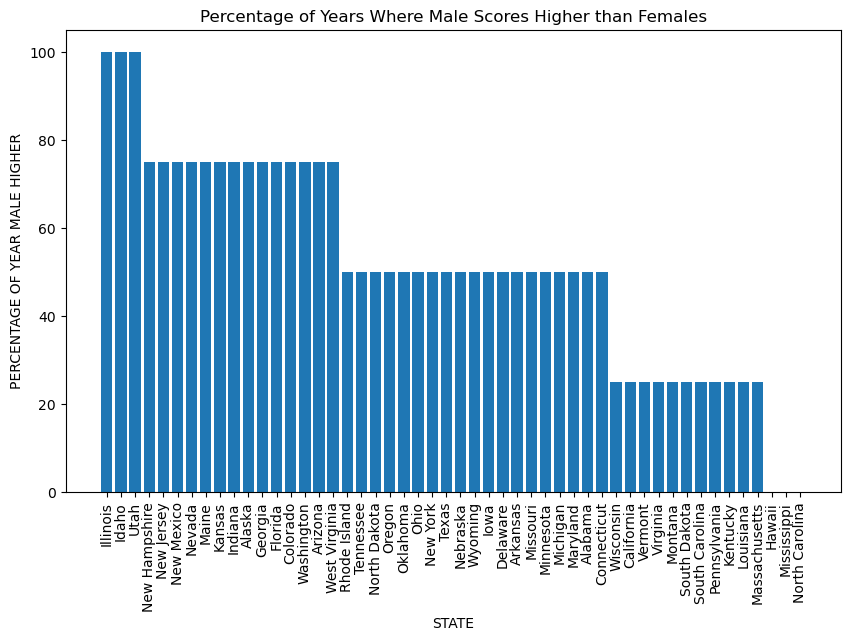

In [18]:
group_by_state = """
SELECT
    state,
    AVG(CASE WHEN male > female THEN 1 ELSE 0 END) * 100 AS percentage_male_higher
FROM math_gencompare
GROUP BY state
"""

df_state = pd.read_sql_query(group_by_state, comb)
df_state_sorted = df_state.sort_values(by = 'percentage_male_higher', ascending = False)
df_state_sorted.head()
plt.figure(figsize = (10,6))
plt.bar(df_state_sorted['state'], df_state_sorted['percentage_male_higher'])
plt.xlabel('STATE')
plt.ylabel('PERCENTAGE OF YEAR MALE HIGHER')
plt.title('Percentage of Years Where Male Scores Higher than Females')
plt.xticks(rotation = 90)
plt.show()

## 2.7 Use a subquery to create an indicator and group by that indicator (6 points)

The following states were the first 6 to expand the right to vote to women before the uniform federal expansion in 1920

- Wyoming 1890
- Colorado 1893
- Utah 1896
- Idaho 1896
- Washington 1910
- California 1911

**A.** Create an indicator `is_early_voter` for whether a state is in that list or not; do so without typing the state names inside the string and instead collapsing the list of states we provide and using something like `format`. Hint on how to combine the state names while preserving the quotes around each: https://stackoverflow.com/questions/12007686/join-a-list-of-strings-in-python-and-wrap-each-string-in-quotation-marks 

**B.** Then, group by the `is_early_voter` indicator and `year` and find the percencentage of states in each group where males had higher scores than females 

**C.** Print the resulting dataframe and interpret. Does early expansion of voting seem to be correlated with girls scoring better on the math tests a century later?

**Hint:** in order to group by the indicator in step b, you may need to use a subquery 

In [19]:
## list of states we provide
list_suffrage = ["Wyoming", "Colorado", "Utah", "Idaho", "Washington", 
                "California"]


In [42]:
## your code here
list_states_formatted = ", ".join([f"'{state}'" for state in list_suffrage])

create_indicator = f"""
SELECT
    *,
    CASE WHEN state IN ({list_states_formatted}) THEN 1 ELSE 0 END AS is_early_voter
FROM math_gencompare
"""

In [47]:
group_by_indicator = f"""
SELECT
    is_early_voter,
    year,
    AVG(CASE WHEN male > female THEN 1 ELSE 0 END) * 100 AS percentage_male_higher
FROM (
    SELECT
        CASE WHEN state IN ({list_states_formatted}) THEN 1 ELSE 0 END AS is_early_voter,
        year,
        male,
        female
    FROM math_gencompare
) AS subquery
GROUP BY is_early_voter, year;
"""

df_indicator_grouped = pd.read_sql_query(group_by_indicator, comb)
df_indicator_grouped

/var/folders/8v/m3bhfypx26q8gdlmpkdbmyf00000gn/T/ipykernel_73119/439217773.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


is_early_voter  year  percentage_male_higher
0               0  2013                 59.0909
1               1  2013                 83.3333
2               0  2015                 54.5455
3               1  2015                 66.6667
4               0  2017                 54.5455
5               1  2017                 83.3333
6               0  2019                 27.2727
7               1  2019                 50.0000

## No, overall, being a state that had women voting early did not result in women scoring better a century later. 

# 3. Explore variation in math score disparities and trends (18 points)

## 3.0 Read in the `acs_wmath.pkl` file (csv is backup) (0 points)

In [25]:
math = pd.read_pickle("../QSS20/acs_wmath.pkl")
math.head()

math_female_2013  math_female_2015  math_female_2017  math_female_2019  math_male_2013  math_male_2015  math_male_2017  math_male_2019 abbrev FIPS  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  \
0        281.388243        280.879362        276.557200        271.915723      281.723376      280.143705      277.451445      276.639877     AK   02                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986   
1        268.920112        266.810672        266.748589        270.473059      269.457456      266.304405      269.820070      267.093325     AL   01                                                                                                                                                                                             0.017019                                                                                                                                                                              0.152765                                                                                                                                                                                             0.026735                                                                                                                                                                                              0.046773   
2        278.381788        274.793326        273.139254        276.007484      277.457662      275.325959      274.352754      272.827299     AR   05                                                                                                                                                                                             0.018760                                                                                                                                                                              0.137646                                                                                                                                                                                             0.026809                                                                                                                                                                                              0.046808   
3        279.249581        282.593875        279.935438        280.527631      280.174389      283.229891      284.522633      279.359156     AZ   04                                                                                                                                                  

## 3.1 Create a visualization where one axis is the state; the other axis is the male 2013 math scores - the female 2013 math scores (gender disparity) (2 points)


You have free rein over additional details but make sure it is informative over what direction of disparity positive versus negative values mean


<Figure size 1000x600 with 0 Axes>

<BarContainer object of 50 artists>

Text(0.5, 1.0, 'Gender Disparity in 2013 Math Scores by State')

Text(0.5, 0, 'State')

Text(0, 0.5, 'Male Math Scores - Female Math Scores')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'AK'),
  Text(1, 0, 'AL'),
  Text(2, 0, 'AR'),
  Text(3, 0, 'AZ'),
  Text(4, 0, 'CA'),
  Text(5, 0, 'CO'),
  Text(6, 0, 'CT'),
  Text(7, 0, 'DE'),
  Text(8, 0, 'FL'),
  Text(9, 0, 'GA'),
  Text(10, 0, 'HI'),
  Text(11, 0, 'IA'),
  Text(12, 0, 'ID'),
  Text(13, 0, 'IL'),
  Text(14, 0, 'IN'),
  Text(15, 0, 'KS'),
  Text(16, 0, 'KY'),
  Text(17, 0, 'LA'),
  Text(18, 0, 'MA'),
  Text(19, 0, 'MD'),
  Text(20, 0, 'ME'),
  Text(21, 0, 'MI'),
  Text(22, 0, 'MN'),
  Text(23, 0, 'MO'),
  Text(24, 0, 'MS'),
  Text(25, 0, 'MT'),
  Text(26, 0, 'NC'),
  Text(27, 0, 'ND'),
  Text(28, 0, 'NE'),
  Text(29, 0, 'NH'),
  Text(30, 0, 'NJ'),
  Text(31, 0, 'NM'),
  Text(32, 0, 'NV'),
  Text(33, 0, 'NY'),
  Tex

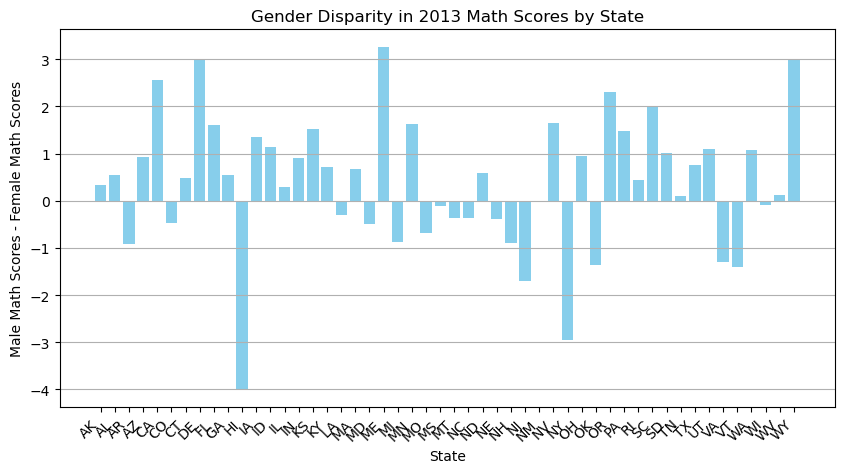

In [14]:
states = math["abbrev"]
diff = math["math_male_2013"] - math["math_female_2013"]

plt.figure(figsize=(10, 6))
plt.bar(states, diff, color='skyblue')

plt.title('Gender Disparity in 2013 Math Scores by State')
plt.xlabel('State')
plt.ylabel('Male Math Scores - Female Math Scores')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.subplots_adjust(bottom=0.25)
plt.grid(axis='y')

## 3.2 Examine gender disparity in relation to household income (6 points)

**A.** Construct an indicator variable for the state having better performance of males in 2013 than females

**B.** First plot a scatterplot (or seaborn regplot) of estimated median household income from the acs data (we provide varname below) vs `math_male_2013`. Then do a second smoothed scatterplot for median household income vs `math_female_2013`.

**C.** 
Then use the `np.corrcoef` command (three separate times) to examine the bivariate correlation of
- male performance
- female performance
- the indicator variable from **A** 

with median household income (`acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars`)

Documentation: https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

**D.** Interpret the correlations - in states with higher median household income (MHI), do 
   - boys tend to perform better than boys in states with lower MHI?
   - girls tend to perform better than girls in states with lower MHI?
   - boys tend to outperform girls more than they do in states with lower MHI?

In [26]:
math["male_states"] = (math["math_male_2013"] > math["math_female_2013"])
math["male_states"].head()

0     True
1     True
2    False
3     True
4     True
Name: male_states, dtype: bool

<Figure size 800x600 with 0 Axes>

/Users/williamhubert/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/williamhubert/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


<Axes: xlabel='acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars', ylabel='math_male_2013'>

Text(0.5, 1.0, 'Estimated Median Household Income vs Math Scores (Males)')

Text(0.5, 0, 'Estimated Median Household Income')

Text(0, 0.5, 'Math Scores (Males)')

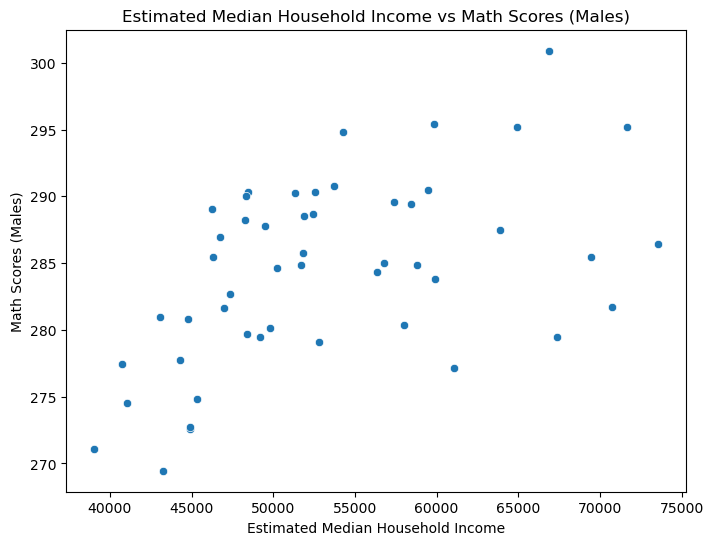

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars', ylabel='math_female_2013'>

Text(0.5, 1.0, 'Estimated Median Household Income vs Math Scores (Females)')

Text(0.5, 0, 'Estimated Median Household Income')

Text(0, 0.5, 'Math Scores (Females)')

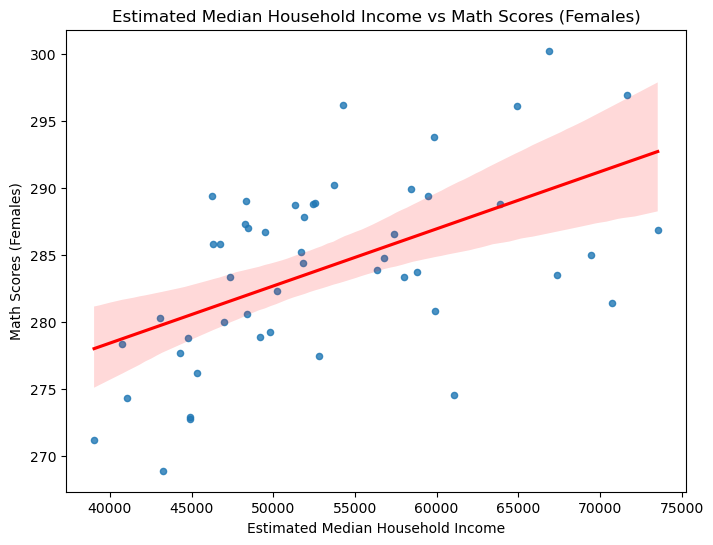

In [27]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=math, x='acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars',
                y='math_male_2013')
plt.title('Estimated Median Household Income vs Math Scores (Males)')
plt.xlabel('Estimated Median Household Income')
plt.ylabel('Math Scores (Males)')
plt.show()

plt.figure(figsize=(8, 6))
sns.regplot(data=math, x='acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars',
            y='math_female_2013', scatter_kws={'s': 20}, line_kws={'color': 'red'})
plt.title('Estimated Median Household Income vs Math Scores (Females)')
plt.xlabel('Estimated Median Household Income')
plt.ylabel('Math Scores (Females)')
plt.show()

In [30]:
male_performance_corr = np.corrcoef(math['math_male_2013'], math['acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars'])
print("Bivariate correlation for male performance:")
print(male_performance_corr)

female_performance_corr = np.corrcoef(math['math_female_2013'], math['acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars'])
print("\nBivariate correlation for female performance:")
print(female_performance_corr)

indicator_corr = np.corrcoef(math['male_states'], math['acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars'])
print("\nBivariate correlation for the indicator variable:")
print(indicator_corr)

Bivariate correlation for male performance:
[[1.         0.50734719]
 [0.50734719 1.        ]]

Bivariate correlation for female performance:
[[1.         0.54337803]
 [0.54337803 1.        ]]

Bivariate correlation for the indicator variable:
[[ 1.        -0.0338752]
 [-0.0338752  1.       ]]


# D
## Boys tend to perform better in states with higher MHI as shown by the 0.51 positive correlation
## Girls also tend to perform better in states with higher MHI as shown by the 0.54 positive correlation
## However, Boys do not tend to dominate girls more in states with higher MHI as shown by the negative 0.03 correlation

## 3.3 Predicting disparities (10 points)

**A.** Read in the raw `acs_wmath` data again (this loses the variables you created above)

**B.** Construct a binary indicator variable for male score > female score  for each year - for full credit, do so without repeating the difference code for each of the four years: name these according to following convention: `outcome_male_higher_female_year` where year is 2013, 2015, 2017, or 2019 (e.g., 2013: `outcome_male_higher_female_2013`). After this, remove the raw math scores as columns in the data (so filter out any column with the word math)

**C.** Melt the data (`acs_wmath`) to long where instead of wide years, years are repeated within state; the ACS vars will also be repeated since we only pulled one year. In other words, reshape the data from "wide format", where each state is a row and we have separate columns for each year, to "long format", where states are repeated four times: once for each year in the data (2013, 2015, 2017, 2019). With 50 states, your final shape should be (200,84).
- See: https://pandas.pydata.org/docs/reference/api/pandas.melt.html

**D.** Split into train-test split at state level (so all years in same state -> either all in train or all test). Randomize 35 states to train; 15 states in test. 

**E.** Normalize the features to mean 0, variance 1 and estimate a decision tree with a max depth of 5. Your covariates should have the term 'acspredict' in it.

- **Hint:** The ML literature recommends using the training set scaler to transform the test set, rather than using a unique scaler to initialize each one. The reasons are discussed here: https://stats.stackexchange.com/questions/495357/why-do-we-normalize-test-data-on-the-parameters-of-the-training-data

**F.** Interpret the feature importances

**G.** Evaluate the precision and recall of that model in the test set states without using the `score`, `precision`, or `recall` functions in sklearn. Briefly interpret: compared to our class example (a high-dimensional feature matrix of yelp reviews with ~15000 observations), why do you think our models perform worse for this set of data/predictors?

**Additional resources:** 

- Feature normalization: https://scikit-learn.org/stable/modules/preprocessing.html

- Definition of precision and recall: https://en.wikipedia.org/wiki/Precision_and_recall

In [35]:
wmath = pd.read_pickle("../QSS20/acs_wmath.pkl")
wmath.head()

math_female_2013  math_female_2015  math_female_2017  math_female_2019  math_male_2013  math_male_2015  math_male_2017  math_male_2019 abbrev FIPS  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  \
0        281.388243        280.879362        276.557200        271.915723      281.723376      280.143705      277.451445      276.639877     AK   02                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986   
1        268.920112        266.810672        266.748589        270.473059      269.457456      266.304405      269.820070      267.093325     AL   01                                                                                                                                                                                             0.017019                                                                                                                                                                              0.152765                                                                                                                                                                                             0.026735                                                                                                                                                                                              0.046773   
2        278.381788        274.793326        273.139254        276.007484      277.457662      275.325959      274.352754      272.827299     AR   05                                                                                                                                                                                             0.018760                                                                                                                                                                              0.137646                                                                                                                                                                                             0.026809                                                                                                                                                                                              0.046808   
3        279.249581        282.593875        279.935438        280.527631      280.174389      283.229891      284.522633      279.359156     AZ   04                                                                                                                                                  

In [38]:
years = [2013, 2015, 2017, 2019]

for year in years:

    indicator_col = f'outcome_male_higher_female_{year}'
    
    wmath[indicator_col] = wmath[f'math_male_{year}'] > wmath[f'math_female_{year}']

math_columns = [col for col in wmath.columns if 'math' in col]
no_math = wmath.drop(columns=math_columns)

no_math


abbrev FIPS  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated  \
0      AK   02                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986                                                                                                                                                         0.010905   
1      AL   01                                                                                                                                                                                             0.017019                                                                                                                                                                              0.152765                                                                                                                                                                                             0.026735                                                                                                                                                                                              0.046773                                                                                                                                                         0.029813   
2      AR   05                                                                                                                                                                                             0.018760                                                                                                                                                                              0.137646                                                                                                                                                                                             0.026809                                                                                                                                                                                              0.046808                                                                                                                                                         0.026058   
3      AZ   04                                                                                                                                                                                 

In [101]:

acs_melt = pd.melt(no_math, id_vars=no_math.columns.difference(['outcome_male_higher_female_2013', 'outcome_male_higher_female_2015', 'outcome_male_higher_female_2017', 'outcome_male_higher_female_2019']), value_vars=['outcome_male_higher_female_2013', 'outcome_male_higher_female_2015', 'outcome_male_higher_female_2017', 'outcome_male_higher_female_2019'])

acs_melt


FIPS abbrev  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated  \
0     02     AK                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986                                                                                                                                                         0.010905   
1     01     AL                                                                                                                                                                                             0.017019                                                                                                                                                                              0.152765                                                                                                                                                                                             0.026735                                                                                                                                                                                              0.046773                                                                                                                                                         0.029813   
2     05     AR                                                                                                                                                                                             0.018760                                                                                                                                                                              0.137646                                                                                                                                                                                             0.026809                                                                                                                                                                                              0.046808                                                                                                                                                         0.026058   
3     04     AZ                                                                                                                                                                             

In [102]:
acs_melt.shape

(200, 86)

In [114]:
states = acs_melt['state'].unique()

train_states = random.sample(states.tolist(), 35)
test_states = [state for state in states if state not in train_states]

train_data = acs_melt[acs_melt['state'].isin(train_states)]
test_data = acs_melt[acs_melt['state'].isin(test_states)]
train_data['state'].nunique()
test_data['state'].nunique()

35

15

In [127]:
X_train = train_data[[col for col in train_data.columns if col not in ["state", "value", "variable"]]]
y_train = train_data[[col for col in train_data.columns if col in ["state", "variable"]]]
X_test = test_data[[col for col in test_data.columns if col not in ["state", "value", "variable"]]]
y_test = test_data[[col for col in test_data.columns if col in ["value"]]]


FIPS abbrev  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated  \
0     02     AK                                                                                                                                                                                             2.461274                                                                                                                                                                             -2.990799                                                                                                                                                                                             0.164155                                                                                                                                                                                              4.728402                                                                                                                                                        -3.629871   
1     01     AL                                                                                                                                                                                            -0.996944                                                                                                                                                                              0.698911                                                                                                                                                                                            -0.203498                                                                                                                                                                                             -0.082749                                                                                                                                                         1.379684   
3     04     AZ                                                                                                                                                                                            -1.013642                                                                                                                                                                              1.100607                                                                                                                                                                                            -0.499409                                                                                                                                                                                             -0.230342                                                                                                                                                         0.285293   
4     06     CA                                                                                                                                                                             

In [132]:
scaler = StandardScaler()

X_train_filter = X_train.filter(like='acspredict')
X_test_filter = X_test.filter(like='acspredict')

X_train_scaled = scaler.fit_transform(X_train_filter)
X_test_scaled = scaler.transform(X_test_filter)

dt_classifier = DecisionTreeClassifier(criterion='gini',  
                                           splitter='random',
                                           max_depth=5,
                                           min_samples_split=5, 
                                           min_samples_leaf=10, 
                                           min_weight_fraction_leaf=0.0, 
                                           max_features=None, 
                                           max_leaf_nodes=None,  
                                           min_impurity_decrease=1e-07, 
                                           random_state = 10)
   
dec_tree = dt_classifier.fit(X_train_scaled, train_data['value'])
dec_tree.score(X_train_scaled, train_data['value'])

0.6785714285714286

In [134]:
feature_importance = dec_tree.feature_importances_
feature_names = list(train_data.filter(like="acspredict"))
paired_columns = list(zip(feature_names, feature_importance))
sorted_paired_columns = sorted(paired_columns, key = lambda x: -x[1])
features_important = pd.DataFrame(sorted_paired_columns, columns = ["Columns", "Value"])
features_important

Columns     Value
0                                                                                                                   acspredict_household_type__including_living_alone__by_relationshipestimatetotalin households  0.402379
1                                                                                                          acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalassociate's degree  0.146418
2                                                                                                      acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalno schooling completed  0.134201
3                                                                                                                   acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal4th grade  0.131387
4                                                                                                                acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalkindergarten  0.100096
5                                                                                                           acspredict_ratio_of_income_to_poverty_level_of_families_in_the_past_12_monthsestimatetotal300 to 399  0.036496
6                                                                                                           acspredict_ratio_of_income_to_poverty_level_of_families_in_the_past_12_monthsestimatetotal100 to 124  0.028837
7                                                                                    acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdsparentinlaw  0.020186
8            acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  0.000000
9                           acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  0.000000
10           acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  0.000000
11          acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  0.000000
12                                               acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated  0.000000
13  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated more than 0 to less than 10 percent of total income for household allocated  0.000000
14                                                          acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated no income allocated  0.000000
15                                                                                                                 acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal10th grade  0.000000
16                                                                                                                 acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal11th grade  0.000000
17                                                                                                      acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal12th grade no diploma  0.000000
18                                      

# F
### The most important factors are household type and level of education obtained by household

In [140]:
y_test_pred = dt_classifier.predict(X_test_scaled)
y_test_pred_prob = dt_classifier.predict_proba(X_test_scaled)

y_pred_df = pd.DataFrame({
    'y_pred_binary': y_test_pred,
    'y_pred_continuous': [one_prob[1] for one_prob in y_test_pred_prob],
    'y_true': y_test.values.flatten() 
})


y_pred_binary  y_pred_continuous  y_true
0            True           0.625000   False
1            True           0.666667    True
2           False           0.333333   False
3           False           0.250000    True
4            True           0.625000   False
5           False           0.250000    True
6            True           0.666667   False
7            True           0.666667   False
8           False           0.500000   False
9            True           0.750000    True
10           True           0.666667    True
11           True           0.750000    True
12          False           0.200000    True
13           True           0.666667   False
14           True           0.916667    True
15           True           0.625000    True
16           True           0.666667    True
17          False           0.333333   False
18          False           0.250000    True
19           True           0.625000   False
20          False           0.250000    True
21           True           0.666667    True
22           True           0.666667    True
23          False           0.500000    True
24           True           0.750000    True
25           True           0.666667   False
26           True           0.750000   False
27          False           0.200000   False
28           True           0.666667    True
29           True           0.916667    True
30           True           0.625000    True
31           True           0.666667   False
32          False           0.333333   False
33          False           0.250000   False
34           True           0.625000    True
35          False           0.250000   False
36           True           0.666667    True
37           True           0.666667    True
38          False           0.500000    True
39           True           0.750000    True
40           True           0.666667    True
41           True           0.750000    True
42          False           0.200000    True
43           True           0.666667   False
44           True           0.916667    True
45           True           0.625000   False
46           True           0.666667   False
47          False           0.333333   False
48          False           0.250000    True
49           True           0.625000   False
50          False           0.250000    True
51           True           0.666667   False
52           True           0.666667    True
53          False           0.500000    True
54           True           0.750000   False
55           True           0.666667   False
56           True           0.750000   False
57          False           0.200000   False
58           True           0.666667   False
59           True           0.916667   False

In [149]:
error_cond = [
    (y_pred_df['y_true'] == 1) & (y_pred_df['y_pred_binary'] == 1),
    (y_pred_df['y_true'] == 1) & (y_pred_df['y_pred_binary'] == 0),
    (y_pred_df['y_true'] == 0) & (y_pred_df['y_pred_binary'] == 0)
]

error_codeto = ["TP", "FN", "TN"]

y_pred_df['error_cat'] = np.select(error_cond, error_codeto, default="FP")
y_error = y_pred_df['error_cat'].value_counts().reset_index().copy()
y_error.columns = ['cat', 'n']

precision = y_error.loc[y_error.cat == "TP", 'n'].iloc[0] / (
    y_error.loc[y_error.cat == "TP", 'n'].iloc[0] + y_error.loc[y_error.cat == "FP", 'n'].iloc[0]
)
recall = y_error.loc[y_error.cat == "TP", 'n'].iloc[0] / (
    y_error.loc[y_error.cat == "TP", 'n'].iloc[0] + y_error.loc[y_error.cat == "FN", 'n'].iloc[0]
)

print("Precision is:", precision)
print("Recall is:", recall)

Precision is: 0.525
Recall is: 0.65625


# G
### Our models perform worse because they have a much smaller sample size than the Yelp dataset with 15000 reviews. Therefore, they have less to make predictions off of and will be less accurate.